# Libraries

In [21]:
import warnings
warnings.filterwarnings("ignore")
from torchvision.io.video import read_video
from torchvision.models.video import r3d_18,R3D_18_Weights,s3d,S3D_Weights, mc3_18, MC3_18_Weights, r2plus1d_18, R2Plus1D_18_Weights
from torch.utils.data import Dataset
import torch.nn as nn
from torchvision.io import read_video
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import torch
import random
from collections import defaultdict
import numpy as np
import time
import shutil
import pandas as pd
from tqdm import tqdm
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader
import os

In [22]:
r2plus1d_18()

VideoResNet(
  (stem): R2Plus1dStem(
    (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
    (1): BatchNorm3d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv2Plus1D(
          (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
          (1): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
        )
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [23]:
r3d_18()

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [24]:
mc3_18()

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [25]:
s3d()

S3D(
  (features): Sequential(
    (0): TemporalSeparableConv(
      (0): Conv3dNormActivation(
        (0): Conv3d(3, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
        (1): BatchNorm3d(64, eps=0.001, momentum=0.001, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Conv3dNormActivation(
        (0): Conv3d(64, 64, kernel_size=(7, 1, 1), stride=(2, 1, 1), padding=(3, 0, 0), bias=False)
        (1): BatchNorm3d(64, eps=0.001, momentum=0.001, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    (2): Conv3dNormActivation(
      (0): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (1): BatchNorm3d(64, eps=0.001, momentum=0.001, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): TemporalSeparableConv(
      (0): Conv3d

# Models_params

In [26]:
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = "cpu"
BATCH_SIZE = 1

EPOCHS = 5

FEATURE_EXTRACT = True

USE_WEIGHTS = True

MODELS_NAMES = ['r2plus1d_18']

TRAIN_SIZE = 0.8


# Train Test folder

In [27]:
train_dir = './train'
validation_dir = './validation'

for  i in [train_dir, validation_dir]:
    try:
        os.mkdir(i)
    except FileExistsError as ex:
        pass

# Move to train/test from data

In [28]:

start_folder = './data/'
def train_test_shuffle(start_folder):
    for root, folders, videos_filename in os.walk(start_folder):
        print('Current folder:', root)
        print('Subfolders:', len(folders))
        print('Files:', len(videos_filename))
        print()
        if(root !='./data/'):
            random.shuffle(videos_filename)
            videos_number = len(videos_filename)

            for i, vid in enumerate(videos_filename):
                if i < round(videos_number * TRAIN_SIZE):
                    shutil.move(root+'/'+vid,train_dir)
                else:
                    shutil.move(root+'/'+vid,validation_dir)
            

train_test_shuffle(start_folder)


Current folder: ./data/
Subfolders: 2
Files: 0

Current folder: ./data/BasketballDunk
Subfolders: 0
Files: 0

Current folder: ./data/BandMarching
Subfolders: 0
Files: 0



# Create_csv_dataset

In [29]:
def create_csv_dataset(path, encodre_decoder):
    
    df = pd.DataFrame(columns=['vid','target'])
    vid_names = os.listdir(path)
    target_names_list = []
    for vid_name in tqdm(vid_names):
        target_names_list.append(vid_name.split('_')[1])
    
    # print(target_names_list)
    if(encodre_decoder is not None):
        encodre_decoder.code(list(set(target_names_list)))
    
    
    for vid_name in tqdm(vid_names):
        if(encodre_decoder is not None):
            df.loc[len(df)] = [vid_name, encodre_decoder.code([(vid_name.split('_'))[1]])[0]]
        else:
            df.loc[len(df)] = [vid_name, [(vid_name.split('_'))[1]]]
        
    if "train" in path:
        df.to_csv(f'./train_data.csv')
    else:
        df.to_csv(f'./val_data.csv')
        
    return df

In [30]:

class S3D(nn.Module):
    def __init__(self):
        super(S3D, self).__init__()
        self.features[14].branch3[1] = nn.Linear(in_features=512, out_features=1, bias=True)


# Init_model

In [31]:
def initialize_model(model_name, feature_extract, use_weights):
    
    """
    Инициализация модели, которая будет использована для обучения.
    
    Args:
        model_name (_str_): Название используемой модели из документации.
        feature_extract (_bool_): _description_
        use_weights (_bool_): Парамет, указывающий, будем ли мы использовать предобученные веса для данной модели.
    """
    model = None
    
    if 'r3d_18' in model_name:
        if use_weights:
            weights = R3D_18_Weights.KINETICS400_V1
            model = r3d_18(weights=weights)    
        else:
            model = r3d_18().float()

    if 'mc3_18' in model_name:
        if use_weights:
            weights = MC3_18_Weights.KINETICS400_V1
            model = mc3_18(weights=weights)
        else:
            model = mc3_18()

    if 'r2plus1d_18' in model_name:
        if use_weights:
            weights = R2Plus1D_18_Weights.KINETICS400_V1
            model = r2plus1d_18(weights=weights)
        else:
            model = r2plus1d_18()

    if 's3d' in model_name:
        if use_weights:
            weights = S3D_Weights.KINETICS400_V1
            model = S3D(weights=weights)
        else:
            model = S3D()

    if model_name != 's3d':
        model.fc = nn.Linear(in_features=512, out_features=1, bias=True)
        if feature_extract:
            for name, param in model.named_parameters():
                if 'fc' not in name:
                    param.requires_grad = False
    else:
        pass
        

    if(use_weights):
        return model, weights
    else:
        return model

# VideoClassificationDataset

In [32]:

class VideoClassificationDataset(Dataset):
    
    def __init__(self, videos_dir, transform=None,encoder_decoder = None):
        """
        Arguments:
            videos_dir (string): Путь к папке с видеофайлами.
            transform (callable, optional): Преобразования, которые будут применены к видео.
        """
        print("Creating dataset...")
        self.value_to_frame = create_csv_dataset(videos_dir,encoder_decoder)
        print("Dataset created!")
        self.videos_dir = videos_dir
        self.transformer = transform

    def __len__(self):
        return len(self.value_to_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        video_name = os.path.join(self.videos_dir, self.value_to_frame.iloc[idx, 0])
        
    
        frames, _, _ = read_video(video_name, output_format="TCHW")
        frames = frames[:32]
        # print("Video_ shape: ", frames.shape)
        
        targets = float(self.value_to_frame.iloc[idx, 1:])
        # print(targets)
        sample = {'video': frames, 'target': targets}
        # print(sample)
        if self.transformer:
            sample = self.transformer(sample)
        # print("Samle_shape: ", sample['video'].shape)
        return sample

# SingletonEncoderDecoder

In [33]:
class SingletonEncoderDecoder:
    _instance = None
    label_encoder = None

    def __new__(cls, *args, **kwargs):
        if not cls._instance:
            cls._instance = super().__new__(cls, *args, **kwargs)
        return cls._instance
    
    def code(self, video_targets):
        # print("here")
        coded_video = []
        if(self.label_encoder is None):
            self.label_encoder = LabelEncoder()
            coded_video = self.label_encoder.fit_transform(video_targets)
        else: 
            coded_video = self.label_encoder.transform(video_targets)
        return coded_video
    
    def decode(self, coded_video):
        return self.label_encoder.inverse_transform(coded_video)

# train_dataloader validation_dataloader

In [34]:
train_dataloader = DataLoader(VideoClassificationDataset(
    videos_dir='./train',

    encoder_decoder=SingletonEncoderDecoder()),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

validation_dataloader = DataLoader(VideoClassificationDataset(
    videos_dir='./validation',
    encoder_decoder=SingletonEncoderDecoder()),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

Creating dataset...


100%|██████████| 101/101 [00:00<00:00, 1356.64it/s]


Dataset created!
Creating dataset...


100%|██████████| 25/25 [00:00<00:00, 1276.31it/s]

Dataset created!


In [35]:
pd.read_csv("train_data.csv").head(30)

,Unnamed: 0,vid,target
0,0,v_BasketballDunk_g01_c03.avi,1
1,1,v_BandMarching_g10_c02.avi,0
2,2,v_BandMarching_g11_c01.avi,0
3,3,v_BandMarching_g09_c03.avi,0
4,4,v_BandMarching_g06_c04.avi,0
5,5,v_BandMarching_g05_c06.avi,0
6,6,v_BandMarching_g09_c07.avi,0
7,7,v_BasketballDunk_g08_c05.avi,1
8,8,v_BandMarching_g07_c01.avi,0
9,9,v_BandMarching_g11_c02.avi,0


In [36]:
pd.read_csv("val_data.csv").head(30)

,Unnamed: 0,vid,target
0,0,v_BandMarching_g08_c02.avi,0
1,1,v_BasketballDunk_g02_c04.avi,1
2,2,v_BasketballDunk_g05_c05.avi,1
3,3,v_BasketballDunk_g09_c03.avi,1
4,4,v_BasketballDunk_g05_c01.avi,1
5,5,v_BasketballDunk_g03_c01.avi,1
6,6,v_BandMarching_g08_c07.avi,0
7,7,v_BandMarching_g03_c07.avi,0
8,8,v_BasketballDunk_g02_c02.avi,1
9,9,v_BasketballDunk_g03_c06.avi,1


# plot

In [37]:
def plot_learning_curves(history):
    '''
    Функция для построения графиков лоса и точности.

    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

# Trainf_def

In [38]:
def train(
    model,
    model_params,
    criterion,
    optimizer,
    train_dataloader,
    val_dataloader,
    weights,
    num_epochs=15
):

    
    history = defaultdict(lambda: defaultdict(list))
    valid_loss_min = np.inf
    
    # current_directory = os.getcwd()
    # print("Текущая рабочая папка:", current_directory)
    model_save_dir = f'./models/{model_params[0]}'
    try:
        os.makedirs(model_save_dir)
    except FileExistsError as ex:
        pass

    for epoch in range(num_epochs):
        train_loss = 0
        val_loss = 0

        start_time = time.time()

        # Set the model to training mode
        model.train(True)
        model.to(DEVICE)
        # print(model_params)
        # Training loop
        print('Training')
        for batch in tqdm(train_dataloader):
            
            preprocess = weights.transforms()
            # Move batch to the device
            # print("Batch_vid_shape:",batch['video'].shape)
            X_batch = preprocess(batch['video']).float().to(DEVICE)
            # print("X_batch_shape:",X_batch.shape)
            y_batch = batch['target'].float().to(DEVICE)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        history['loss']['train'].append(train_loss)

        # Set the model to evaluation mode
        model.eval()
        print('Validation')
        with torch.no_grad():
            # Validation loop
            for batch in tqdm(val_dataloader):
                # Move batch to the device
                preprocess = weights.transforms()
                # Move batch to the device
                # print("Batch_vid_shape:",batch['video'].shape)
                X_batch = preprocess(batch['video']).float().to(DEVICE)
                # print("X_batch_shape:",X_batch.shape)
                y_batch = batch['target'].float().to(DEVICE)

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        history['loss']['val'].append(val_loss)

        # clear_output()


        # Print results after each epoch
        print(f'Model: {model_params[0]}. LR: {model_params[1]}. Momentum: {model_params[2]}')
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss: \t{:.6f}".format(train_loss))
        print("  validation loss: \t{:.6f}".format(val_loss))
        
        if val_loss < valid_loss_min:
            print(f'Detected network improvement on epoch {epoch},saving the current model')
            valid_loss_min = val_loss
            torch.save(model.cpu(), model_save_dir + f'\\{model_params[0]}_lr{model_params[1]}_mom{model_params[2]}.pth')
        
        plot_learning_curves(history)
    
    model.cpu()   
    return model, history

# prepare_optimizer_and_criterion

In [39]:
def prepare_optimizer_and_criterion(model, learning_rate, moment):
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            params_to_update.append(param)
            print("\t", name + " updating")
    optimizer_ft = torch.optim.SGD(
        params_to_update,
        lr=learning_rate,
        momentum=moment,
        weight_decay=0.05
    )
    criterion = nn.MSELoss()
    return optimizer_ft, criterion


# Train process

	 fc.weight updating
	 fc.bias updating
Training


100%|██████████| 101/101 [01:37<00:00,  1.03it/s]


Validation


100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


Model: r2plus1d_18. LR: 0.0003. Momentum: 0.9
Epoch 1 of 5 took 119.445s
  training loss: 	0.684515
  validation loss: 	0.426251
Detected network improvement on epoch 0,saving the current model
Training


100%|██████████| 101/101 [01:41<00:00,  1.00s/it]


Validation


100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


Model: r2plus1d_18. LR: 0.0003. Momentum: 0.9
Epoch 2 of 5 took 123.393s
  training loss: 	0.446946
  validation loss: 	0.765717
Training


100%|██████████| 101/101 [01:40<00:00,  1.00it/s]


Validation


100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


Model: r2plus1d_18. LR: 0.0003. Momentum: 0.9
Epoch 3 of 5 took 123.094s
  training loss: 	0.358440
  validation loss: 	0.198818
Detected network improvement on epoch 2,saving the current model
Training


100%|██████████| 101/101 [01:40<00:00,  1.00it/s]


Validation


100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


Model: r2plus1d_18. LR: 0.0003. Momentum: 0.9
Epoch 4 of 5 took 123.109s
  training loss: 	0.346570
  validation loss: 	0.353360
Training


100%|██████████| 101/101 [01:42<00:00,  1.02s/it]


Validation


100%|██████████| 25/25 [00:22<00:00,  1.13it/s]


Model: r2plus1d_18. LR: 0.0003. Momentum: 0.9
Epoch 5 of 5 took 125.041s
  training loss: 	0.311965
  validation loss: 	0.128154
Detected network improvement on epoch 4,saving the current model


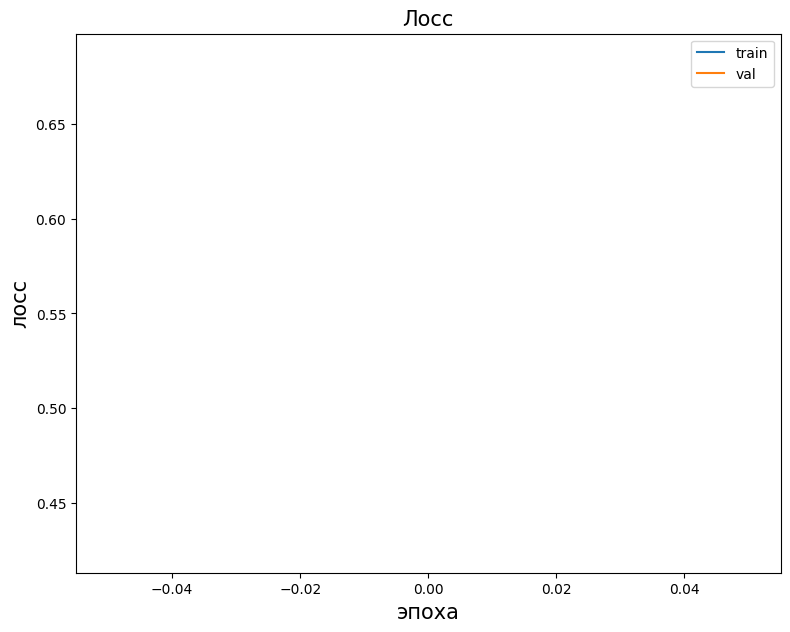

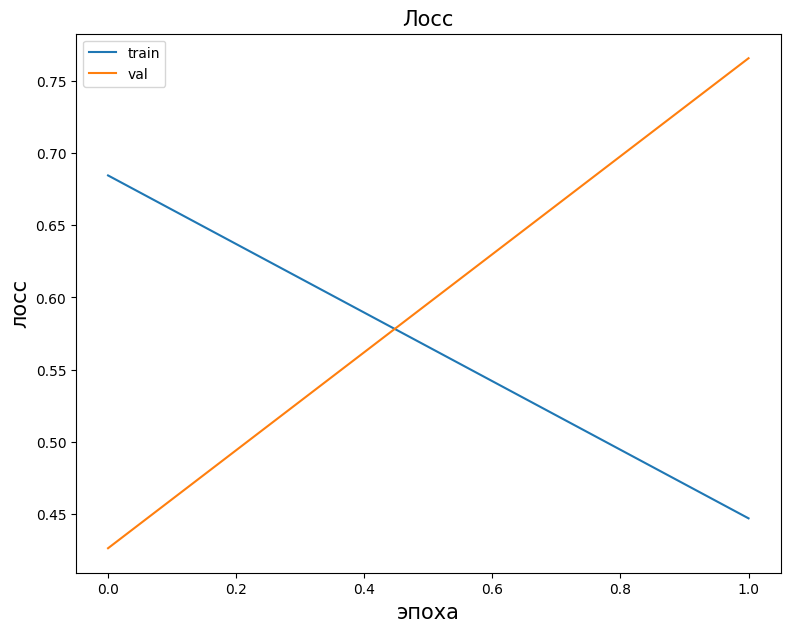

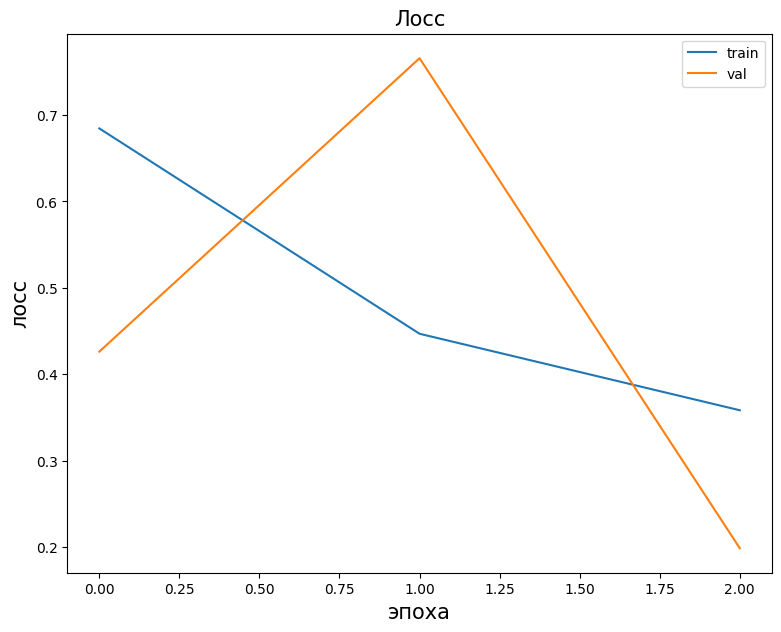

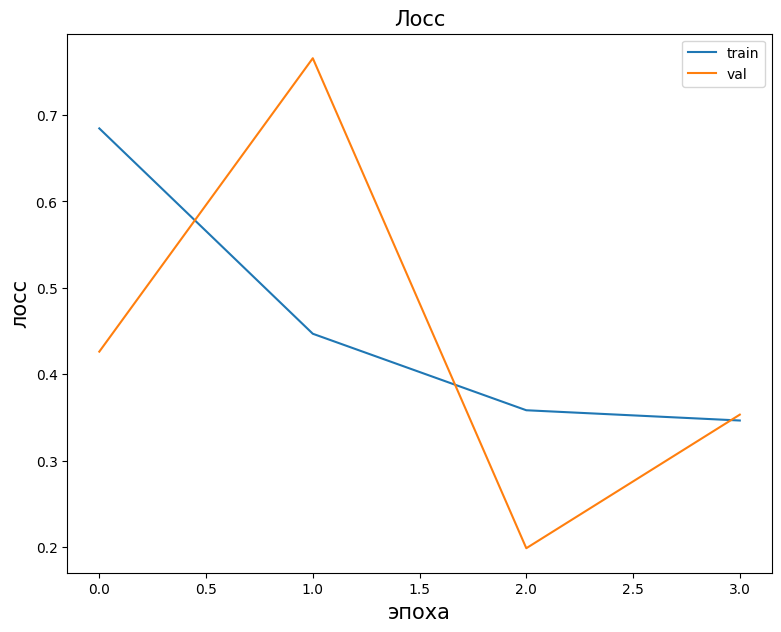

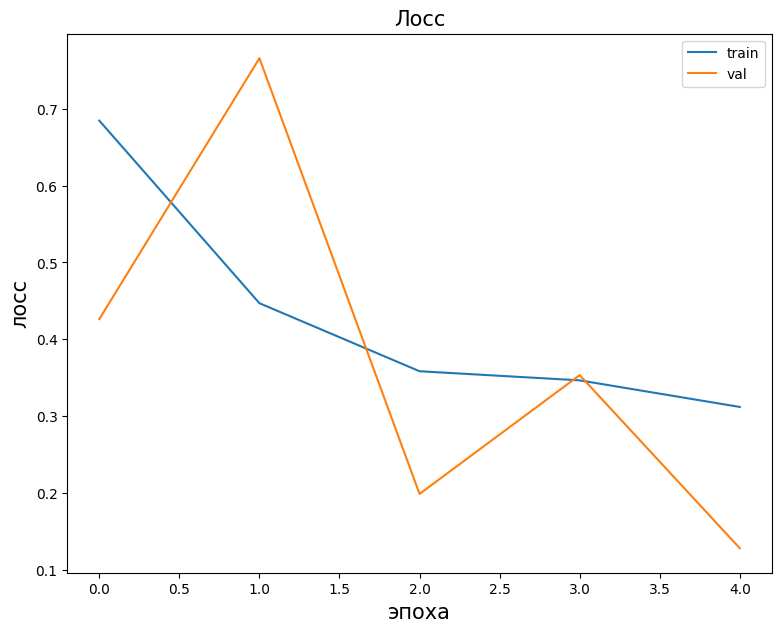

In [40]:
current_directory = os.getcwd()

try:
    os.mkdir(current_directory + '\\models')
except FileExistsError as ex:
    pass

for model_name in MODELS_NAMES:
    for learning_rate in [0.0003]:
        for moment in [0.9]:
            model, weights = initialize_model(model_name, FEATURE_EXTRACT, USE_WEIGHTS)  
            model = model.to(DEVICE)
            optimizer, criterion = prepare_optimizer_and_criterion(model, learning_rate, moment)
            model_params = [model_name, learning_rate, moment]
            model, history = train(
                model,
                model_params,
                criterion,
                optimizer,
                train_dataloader,
                validation_dataloader,
                weights,
                EPOCHS
            )
            time.sleep(5)
            torch.cuda.empty_cache()